In [80]:
# Import all libraries
import os
import yaml
import zipfile
import cv2
import joblib
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image


In [2]:
# Config file
RAW_PATH = "../../data/raw/"
PROCESSED_PATH = "../../data/processed/"

In [81]:
# Utils file
def clean(filename):
    if filename:
        for file in os.listdir(RAW_PATH):
            os.remove(os.path.join(RAW_PATH, file))
    else:
        raise ValueError("File not found".capitalize())
    
def config():
    with open("../../deafult_params.yml", "r") as file:
        return yaml.safe_load(file)
    
def dump_pickle(value = None, filename = None):
    if value is not None and filename is not None:
        joblib.dump(value = value, filename=filename)
        
def load_pickle(filename = None):
    return joblib.load(filename)

In [83]:
class Loader:
    def __init__(self, image_path = None, batch_size = 32):
        self.image_path = image_path
        self.batch_size = batch_size
        self.directory = None
        self.categories = None
        self.base_images = list()
        self.mask_images = list()
        self.is_mask = "mask"

    def base_transformation(self):
        return transforms.Compose(
            [
                transforms.Resize(
                    (config()["data"]["image_width"], config()["data"]["image_height"])
                ),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[
                        config()["data"]["transforms"],
                        config()["data"]["transforms"],
                        config()["data"]["transforms"],
                    ],
                    std=[
                        config()["data"]["transforms"],
                        config()["data"]["transforms"],
                        config()["data"]["transforms"],
                    ],
                ),
            ]
        )

    def mask_transformation(self):
        return transforms.Compose(
            [
                transforms.Resize(
                    (config()["data"]["image_width"], config()["data"]["image_height"])
                ),
                transforms.ToTensor(),
                transforms.Grayscale(
                    num_output_channels=config()["data"]["gray_channels"]
                ),
                transforms.Normalize(
                    mean=[
                        config()["data"]["transforms"],
                    ],
                    std=[
                        config()["data"]["transforms"],
                    ],
                ),
            ]
        )

    def unzip_folder(self):
        if os.path.exists(RAW_PATH):
            with zipfile.ZipFile(self.image_path, "r") as zip_ref:
                zip_ref.extractall(os.path.join(RAW_PATH))
        else:
            os.makedirs(RAW_PATH)

    def split_dataset(self, **kwargs):
        X_train, X_test, y_train, y_test = train_test_split(
            kwargs["base_images"], kwargs["mask_images"], test_size=0.30, random_state=42)
        return X_train, X_test, y_train, y_test

    def create_dataloader(self):
        self.directory = os.path.join(RAW_PATH, [d for d in os.listdir(RAW_PATH) if os.path.isdir(os.path.join(RAW_PATH, d))][0])
        self.categories = [d for d in os.listdir(self.directory) if os.path.isdir(os.path.join(self.directory, d))]

        for category in self.categories:
            folder_path = os.path.join(self.directory, category)
            for image in os.listdir(folder_path):
                if self.is_mask in image:
                    continue

                base_image = image.split(".")[0]
                extension = image.split(".")[1]
                mask_image = "{}_{}.{}".format(base_image, self.is_mask, extension)

                self.base_images.append(
                    self.base_transformation()(
                        Image.fromarray(cv2.imread(os.path.join(folder_path, image)))))

                self.mask_images.append(
                    self.mask_transformation()(
                        Image.fromarray(cv2.imread(os.path.join(folder_path, mask_image),
                                                    cv2.IMREAD_GRAYSCALE
                ))))

        X_train, X_test, y_train, y_test = self.split_dataset(
            base_images=self.base_images, mask_images=self.mask_images
        )

        if os.path.exists(PROCESSED_PATH):
            dataloader = DataLoader(dataset=list(zip(self.base_images, self.mask_images)), batch_size=self.batch_size, shuffle=True)
            train_dataloader = DataLoader(
                dataset=list(zip(X_train, y_train)), batch_size=self.batch_size, shuffle=True
                )
            val_dataloader = DataLoader(
                dataset=list(zip(X_test, y_test)),
                batch_size=self.batch_size,
                shuffle=True,
            )
            dump_pickle(value=self.base_images, filename=os.path.join(PROCESSED_PATH, "base_images.pkl"))
            dump_pickle(
                value=self.mask_images,
                filename=os.path.join(PROCESSED_PATH, "mask_images.pkl"),
            )
            dump_pickle(
                value=dataloader,
                filename=os.path.join(PROCESSED_PATH, "dataloader.pkl"),
            )
            dump_pickle(
                value=train_dataloader,
                filename=os.path.join(PROCESSED_PATH, "train_dataloader.pkl"),
            )
            dump_pickle(
                value=val_dataloader,
                filename=os.path.join(PROCESSED_PATH, "val_dataloader.pkl"),
            )

            return dataloader

        else:
            raise Exception("PROCESSED_PATH does not exist".capitalize())


if __name__ == "__main__":
    loader = Loader(
        image_path="/Users/shahmuhammadraditrahman/Desktop/semantic.zip", batch_size=4
    )
    loader.unzip_folder()
    dataloader = loader.create_dataloader()

In [12]:
data, label = next(iter(dataloader))
data.size()

torch.Size([32, 3, 256, 256])

In [13]:
import joblib

data = joblib.load(
    "/Users/shahmuhammadraditrahman/Desktop/U-Net/data/processed/dataloader.pkl"
)

data, label = next(iter(data))

print(data.shape)

torch.Size([32, 3, 256, 256])


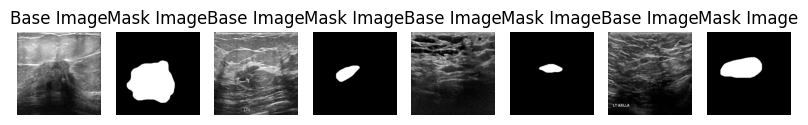

In [18]:
import matplotlib.pyplot as plt
def display_images():
    num_samples = 20
    plt.figure(figsize=(10, 10))
    dataloader = load_pickle(
            filename=os.path.join(PROCESSED_PATH, "dataloader.pkl")
        )
    images, labels = next(iter(dataloader))
    images = images[:num_samples]
    labels = labels[:num_samples]

    for index, image in enumerate(images):
        plt.subplot(2 * 4, 2 * 5, 2 * index + 1)
        image = image.permute(1, 2, 0)
        image = (image - image.min()) / (image.max() - image.min())
        plt.imshow(image, cmap="gray")
        plt.title("Base Image")
        plt.axis("off")

        plt.subplot(2 * 4, 2 * 5, 2 * index + 2)
        label = labels[index].permute(1, 2, 0)
        label = (label - label.min()) / (label.max() - label.min())
        plt.imshow(label, cmap="gray")
        plt.title("Mask Image")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

display_images()

In [19]:
from collections import OrderedDict

class Encoder(nn.Module):
    def __init__(self, in_channels=None, out_channels=None):
        super(Encoder, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.model = self.encoder_block()

    def encoder_block(self):
        layers = OrderedDict()
        layers["conv1"] = nn.Conv2d(
            in_channels=self.in_channels,
            out_channels=self.out_channels,
            kernel_size=3,
            stride=1,
            padding=1,
        )
        layers["relu1"] = nn.ReLU(inplace=True)
        layers["conv2"] = nn.Conv2d(
            in_channels=self.out_channels,
            out_channels=self.out_channels,
            kernel_size=3,
            stride=1,
            padding=1,
        )
        layers["batch_norm1"] = nn.BatchNorm2d(self.out_channels)
        layers["relu2"] = nn.ReLU(inplace=True)

        return nn.Sequential(layers)

    def forward(self, x):
        return self.model(x) if x is not None else None
    
if __name__ == "__main__":
    encoder = Encoder(in_channels=3, out_channels=64)
    assert encoder(torch.randn(64, 3, 256, 256)).shape == (64, 64, 256, 256)

In [20]:
from collections import OrderedDict

class Decoder(nn.Module):
    def __init__(self, in_channels=None, out_channels=None):
        super(Decoder, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.model = self.decoder_block()

    def decoder_block(self):
        layers = OrderedDict()
        layers["deconv1"] = nn.ConvTranspose2d(
            in_channels=self.in_channels,
            out_channels=self.out_channels,
            kernel_size=2,
            stride=2,
        )
        return nn.Sequential(layers)

    def forward(self, x, skip_info):
        if x is not None and skip_info is not None:
            return torch.cat((self.model(x), skip_info), dim=1)
        else:
            raise ValueError("Input and skip_info cannot be None".capitalize())

if __name__ == "__main__":
    encoder = Encoder(in_channels=3, out_channels=64)
    decoder = Decoder(in_channels=64, out_channels=64)
    
    skip_info = encoder(torch.randn(64, 3, 256, 256))
    noise_samples = torch.randn(64, 64, 128, 128)
    
    assert decoder(noise_samples, skip_info).shape == (64, 128, 256, 256)

In [143]:
import torch.nn as nn


class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder_layer1 = Encoder(in_channels=3, out_channels=64)
        self.encoder_layer2 = Encoder(in_channels=64, out_channels=128)
        self.encoder_layer3 = Encoder(in_channels=128, out_channels=256)
        self.encoder_layer4 = Encoder(in_channels=256, out_channels=512)
        self.bottom_layer = Encoder(in_channels=512, out_channels=1024) 

        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.intermediate_layer1 = Encoder(in_channels=1024, out_channels=512)
        self.intermediate_layer2 = Encoder(in_channels=512, out_channels=256)
        self.intermediate_layer3 = Encoder(in_channels=256, out_channels=128)
        self.intermediate_layer4 = Encoder(in_channels=128, out_channels=64)
        
        self.decoder_layer1 = Decoder(in_channels=1024, out_channels=512)
        self.decoder_layer2 = Decoder(in_channels=512, out_channels=256)
        self.decoder_layer3 = Decoder(in_channels=256, out_channels=128)
        self.decoder_layer4 = Decoder(in_channels=128, out_channels=64)

        self.final_layer = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Encoder path
        enc1_out = self.encoder_layer1(x)
        pooled_enc1 = self.max_pool(enc1_out)

        enc2_out = self.encoder_layer2(pooled_enc1)
        pooled_enc2 = self.max_pool(enc2_out)

        enc3_out = self.encoder_layer3(pooled_enc2)
        pooled_enc3 = self.max_pool(enc3_out)

        enc4_out = self.encoder_layer4(pooled_enc3)
        pooled_enc4 = self.max_pool(enc4_out)

        bottom_out = self.bottom_layer(pooled_enc4)

        # Decoder path
        dec1_input = self.decoder_layer1(bottom_out, enc4_out)
        dec1_out = self.intermediate_layer1(dec1_input)

        dec2_input = self.decoder_layer2(dec1_out, enc3_out)
        dec2_out = self.intermediate_layer2(dec2_input)

        dec3_input = self.decoder_layer3(dec2_out, enc2_out)
        dec3_out = self.intermediate_layer3(dec3_input)

        dec4_input = self.decoder_layer4(dec3_out, enc1_out)
        dec4_out = self.intermediate_layer4(dec4_input)

        # Final output
        final_output = self.final_layer(dec4_out)

        return final_output

In [140]:
unet = UNet()
unet(torch.randn(32, 3, 256, 256)).shape


torch.Size([32, 1, 256, 256])

In [19]:
sum(params.numel() for params in unet.parameters())

31037633

In [144]:
dataloader = joblib.load(filename="../../data/processed/dataloader.pkl")

train_dataloader = joblib.load(filename="../../data/processed/train_dataloader.pkl")

val_dataloader = joblib.load(filename="../../data/processed/val_dataloader.pkl")

In [142]:
smooth = 0.01
def dice_loss(pred, target):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    dice = (2.0 * intersection + smooth) / (pred.sum() + target.sum() + smooth)
    return dice

In [145]:
import torch.nn as nn


def weight_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [104]:
import torch.optim as optim

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

model = UNet().to(device)
model.apply(weight_init)

# criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [25]:
print(sum(data.size(0) for data, label in train_dataloader))
print(sum(data.size(0) for data, label in val_dataloader))

546
234


In [ ]:
import numpy as np

epochs = 100

for epoch in range(epochs):
    total_train_loss = list()
    total_test_loss = list()
    for index, (image, mask) in enumerate(train_dataloader):
        image = image.to(device)
        mask = mask.to(device)

        optimizer.zero_grad()

        train_predicted_mask = model(image)
        train_loss = dice_loss(train_predicted_mask, mask)  # without l2

        train_loss.backward(retain_graph=True)
        optimizer.step()

        total_train_loss.append(train_loss.item())

    for val_image, val_mask in val_dataloader:
        val_image = val_image.to(device)
        val_mask = val_mask.to(device)

        val_predicted_mask = model(val_image)
        val_loss = dice_loss(val_predicted_mask, val_mask)

        total_test_loss.append(val_loss.item())

    print(
        "Epochs - [{}/{}] - Steps - [{}/{}] - train_loss: {} - val_loss: {}".format(
            epoch + 1,
            epochs,
            index + 1,
            len(train_dataloader),
            np.mean(total_train_loss),
            np.mean(total_test_loss),
        )
    )

torch.Size([4, 3, 256, 256])


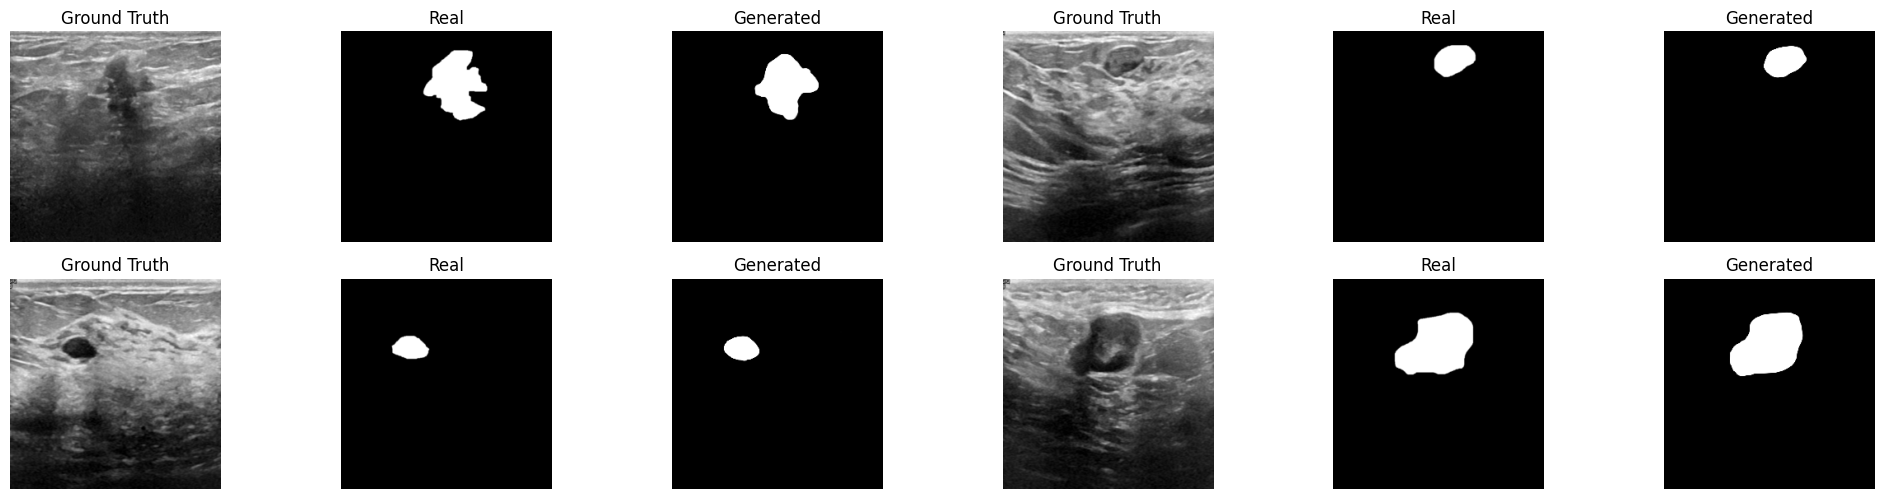

In [134]:
images, masks = next(iter(train_dataloader))
# Ensure base_image is a tensor here, if `images` is not, you might need to convert it back to a tensor.
base_image = images.clone()  # Use clone() to keep the original tensor unchanged

print(base_image.shape)
images = model(images.to(device))

plt.figure(figsize=(20, 15))
for index, image in enumerate(images):
    plt.subplot(3 * 2, 3 * 2, 3 * index + 1)
    temp_base_image = base_image[index].permute(1, 2, 0).cpu().detach().numpy()
    temp_base_image = (temp_base_image - temp_base_image.min()) / (
        temp_base_image.max() - temp_base_image.min()
    )
    plt.imshow(temp_base_image, cmap="gray")
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(3 * 2, 3 * 2, 3 * index + 2)
    mask = masks[index].permute(1, 2, 0).cpu().detach().numpy()
    mask = (mask - mask.min()) / (mask.max() - mask.min())
    plt.imshow(mask, cmap="gray")
    plt.title("Real")
    plt.axis("off")

    plt.subplot(3 * 2, 3 * 2, 3 * index + 3)  # Corrected subplot index for "Generated"
    image = image.permute(1, 2, 0).cpu().detach().numpy()
    image = (image - image.min()) / (image.max() - image.min())
    plt.imshow(image, cmap="gray")
    plt.title("Generated")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [146]:
def device_init(device = "mps"):
    if device == "mps":
        return torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    elif device == "cuda":
        return torch.device("cuda" if torch.cuda.is_available() else "cpu")
    else:
        return torch.device("cpu")

In [147]:
class Trainer():
    def __init__(self, smooth_value = 0.01, epochs = 100, learning_rate = 0.0002, beta1 = 0.5, beta2 = 0.999, device = "mps", display = True):
        self.epochs = epochs
        self.smooth_value = smooth_value
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.device = device
        self.display = display
        self.history = {
            "train_loss":list(),
            "val_loss":list()
            }

    def __setup__(self):
        self.device = device_init(device = self.device)
        self.model = model.apply(weight_init)
        self.optimizer = optim.Adam(
            self.model.parameters(),
            lr=self.learning_rate,
            betas=(self.beta1, self.beta2),
        )

    def dice_loss(self, predicted, target):
        predicted = predicted.view(-1)
        target = target.view(-1)
        intersection = (predicted * target).sum() + self.smooth_value
        return (2. * intersection)/ (predicted.sum() + target.sum() + self.smooth_value)

    def train_model(self, **kwargs):
        self.optimizer.zero_grad()

        predicted_mask = model(kwargs["train_image"])
        train_loss = self.dice_loss(predicted_mask, kwargs["train_mask"])

        train_loss.backward(retain_graph = True)
        self.optimizer.step()

        return train_loss.item()

    def val_model(self, **kwargs):
        self.optimizer.zero_grad()

        predicted_mask = model(kwargs["val_image"])
        val_loss = self.dice_loss(predicted_mask, kwargs["val_mask"])

        return val_loss.item()

    def show_progress(self, **kwargs):
        if self.display:
            print(
                f"Epoch: {kwargs['epoch']}, Train Loss: {kwargs['train_loss']}, Val Loss: {kwargs['val_loss']}")

    def train(self):
        self.__setup__()

        for epoch in range(self.epochs):
            total_train_loss = list()
            total_val_loss = list()
            for _, (image, mask) in enumerate(train_dataloader):
                train_image = image.to(self.device)
                train_mask = mask.to(self.device)

                train_loss = self.train_model(train_image = train_image, train_mask = train_mask)
                total_train_loss.append(train_loss)

            for _, (image, mask) in enumerate(val_dataloader):
                val_image = image.to(self.device)
                val_mask = mask.to(self.device)

                val_loss = self.val_model(val_image = val_image, val_mask = val_mask)
                total_val_loss.append(val_loss)

            self.history["train_loss"].append(np.mean(total_train_loss))
            self.history["val_loss"].append(np.mean(total_val_loss))

            self.show_progress(
                epoch = epoch, train_loss = np.mean(total_train_loss), val_loss = np.mean(total_val_loss))

In [148]:
if __name__ == "__main__":
    trainer = Trainer(epochs = 100, learning_rate = 0.0002, beta1 = 0.5, beta2 = 0.999, device = "mps", display = True)
    
    trainer.train()

Epoch: 0, Train Loss: 1.2585705879830966, Val Loss: 0.9091600260492099
Epoch: 1, Train Loss: 0.7091127460020302, Val Loss: 0.5487352655095569
Epoch: 2, Train Loss: 0.4374106045622025, Val Loss: 0.34329952274338676
Epoch: 3, Train Loss: 0.2834381059247212, Val Loss: 0.2287774560815197
Epoch: 4, Train Loss: 0.18620553036240767, Val Loss: 0.17211205284979383
Epoch: 5, Train Loss: 0.11687753579144224, Val Loss: 0.091077675379939
Epoch: 6, Train Loss: 0.0677481707628225, Val Loss: 0.05918081681899158
Epoch: 7, Train Loss: 0.03318489919821086, Val Loss: 0.0179239039731575
Epoch: 8, Train Loss: 0.014029960702071442, Val Loss: -6.90268780552719e-05
Epoch: 9, Train Loss: -0.008686497106567794, Val Loss: -0.0026869557973518334
Epoch: 10, Train Loss: -0.022217690043515072, Val Loss: -0.024715980779284896
Epoch: 11, Train Loss: -0.035991567577894804, Val Loss: -0.026107121163276733
Epoch: 12, Train Loss: -0.044665801135549514, Val Loss: -0.041327448711746324
Epoch: 13, Train Loss: -0.0504144942060

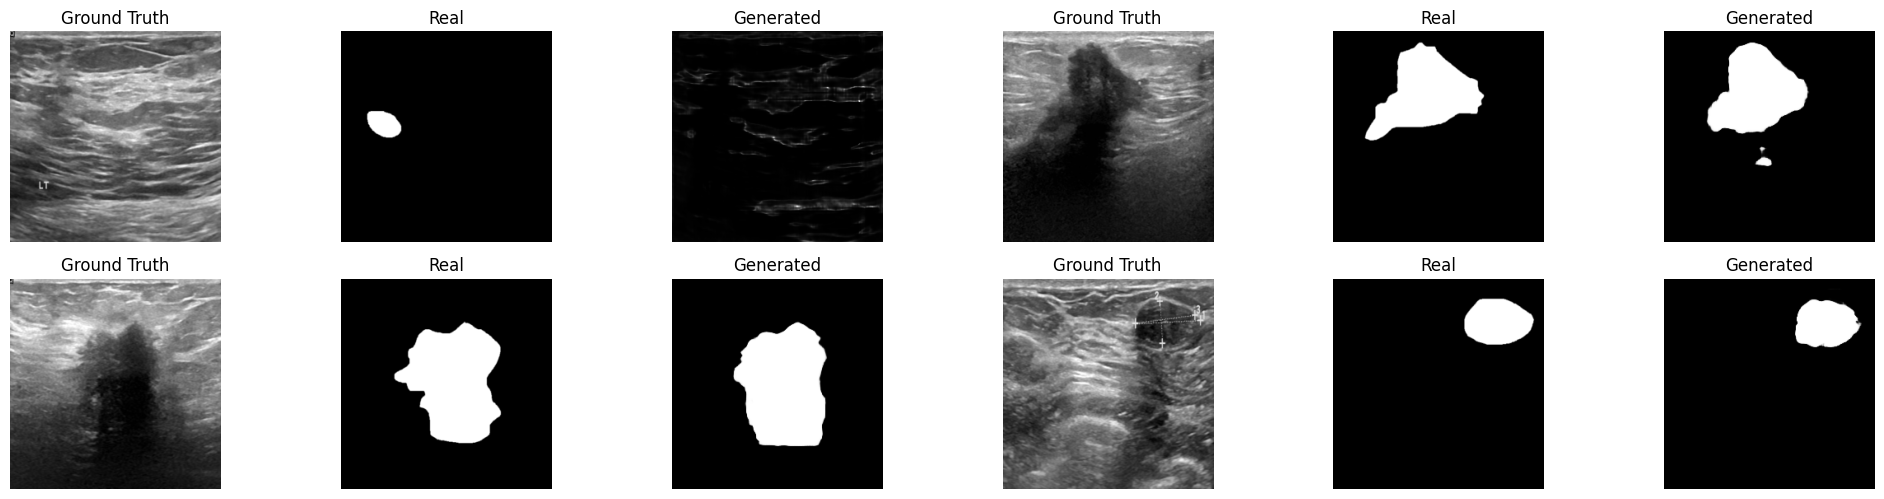

In [156]:
images, masks = next(iter(train_dataloader))

base_image = images.clone()

images = model(images.to(device))

plt.figure(figsize=(20, 15))
for index, image in enumerate(images):
    plt.subplot(3 * 2, 3 * 2, 3 * index + 1)
    temp_base_image = base_image[index].permute(1, 2, 0).cpu().detach().numpy()
    temp_base_image = (temp_base_image - temp_base_image.min()) / (
        temp_base_image.max() - temp_base_image.min()
    )
    plt.imshow(temp_base_image, cmap="gray")
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(3 * 2, 3 * 2, 3 * index + 2)
    mask = masks[index].permute(1, 2, 0).cpu().detach().numpy()
    mask = (mask - mask.min()) / (mask.max() - mask.min())
    plt.imshow(mask, cmap="gray")
    plt.title("Real")
    plt.axis("off")

    plt.subplot(3 * 2, 3 * 2, 3 * index + 3)
    image = image.permute(1, 2, 0).cpu().detach().numpy()
    image = (image - image.min()) / (image.max() - image.min())
    plt.imshow(image, cmap="gray")
    plt.title("Generated")
    plt.axis("off")

plt.tight_layout()
plt.show()